# Generating a GSE Circuit for Analysis
<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:
import sys
import os
from pyLIQTR.GSE.GSE                import GSE 

from openfermion.chem import MolecularData
from cirq.contrib.svg import SVGCircuit

from pyLIQTR.QSP.qsp_helpers             import qsp_decompose_once, print_to_openqasm
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform


## Define the Hamiltonian
The user can select from the four pre-calculated molecules for this demonstration. The default is to use $H_2$ as it is the smallest molecule and therefore fastest to work with.

In [2]:
###
### Select the molecule to use. Note, this is hard-coded, so 
### please uncomment only the line for the molecule you wish 
### to use.
###
molecule_to_use = 'H2'
# molecule_to_use = 'H4'
# molecule_to_use = 'H8'
# molecule_to_use = 'LiH'

### 
### Define the file that holds the molecular hamiltoninan
###
file_name = f'{molecule_to_use}_Molecule.hdf5'

###
### In try...except... to smooth out execution
###
try:
    molecule  = MolecularData(filename=file_name)
    ###
    ### Load the molecule:
    ###
    molecule.load()

    ###
    ### Get the molecular hamiltonian, which is an openfermion object
    ###
    mol_ham = molecule.get_molecular_hamiltonian()

    ###
    ### Output some information to the screen:
    ###
    print(f'> GS energy   = {molecule.hf_energy}')
    print(f'> n electrons = {molecule.n_electrons}')
    print(f'> n orbitals  = {molecule.n_orbitals}')
    print(f'> n qubits    = {mol_ham.n_qubits}')

except:
    print(f'> File {file_name} does not exist.')
    print(f'> Please select one of the pre-calculated molecules from:')
    print(f'\tH2')
    print(f'\tH4')
    print(f'\tH8')
    print(f'\tLiH')
    


> GS energy   = -1.116684387085341
> n electrons = 2
> n orbitals  = 2
> n qubits    = 4


## Generate the circuit
Note, for the circuit analysis, the initial state and the energy interval are only marginally important. The default setup for this cell is to calculate the ground state properties of $H_2$

In [3]:
###
### Perform the simulation and estimate the energies
### for state |0000> which has an associated energy 
### of ~0.813 (for H_2)
###

###
### There are a number of parameters that a user can 
### modify that will impact the resulting GSE circuit
### They are discussed below.
###

###
### The trotter order and trotter steps determine 
### how the user wants to estimate the Hamiltonian.
### Higher values will generally result in a more 
### accurateestimation of the Hamiltonian, but will 
### also generate a longer circuit.
### 
### The precision_order determines how many precision
### bits the user wants to measure. The higher the 
### value the longer the circuit.
###
trotter_order   = 1
trotter_steps   = 1
precision_order = 4

###
### The E_max and E_min values determine the energy
### interval for the measurement. These values have 
### a small impact on circuit length, but are critical
### for getting a correct measurement from the simulation
###
### Similarly, the initial state is important for 
### interpretting the output of the simulation. The 
### configuration of the initial state will have a 
### minimal impact on length of the circuit. It will,
### however, play a critical role in resource estimation,
### because the length of the initial state must match
### the number of (active) orbitals in the molecule. As such,
### we check the molecule we're using from the cell above 
### to defin the initial state.
### 
E_max           = 2.0
E_min           = -2.0

if molecule_to_use == 'H2':
    init_state = [0,0,0,0]
elif molecule_to_use == 'H4':
    init_state = [0,0,0,0,0,0,0,0]
elif molecule_to_use == 'H8':    
    init_state    = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
elif molecule_to_use == 'LiH':
    init_state = [0,0,0,0,0,0,0,0,0,0,0,0]


###
### Generating the circuit:
###
H2_kwargs = {
    'trotterize' : True,
    'mol_ham'    : mol_ham,
    'ev_time'    : 1,
    'trot_ord'   : trotter_order,
    'trot_num'   : trotter_steps
}

###
### Note, there are classical bits put into the GSE circuit by
### default so we can be ergonomical with the number of needed
### qubits. However, cirq does not now how to export these
### classical bits to openqasm format. So, there is a flag,
### include_classical_bits, which we set to False below so that
### we can export to openqasm. Note, if that flag is set to False
### the user will NOT be able to successfully simulate the circuit,
### as the classical bits are necessary for that.
###

gse_inst = GSE(
    precision_order=precision_order,
    init_state=init_state,
    E_max = E_max,
    E_min = E_min,
    include_classical_bits=False, # Do this so print to openqasm works
    kwargs=H2_kwargs)

### Store the circuit for future visualization:
gse_circuit = gse_inst.pe_inst.pe_circuit

## Print Circuit to Screen

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


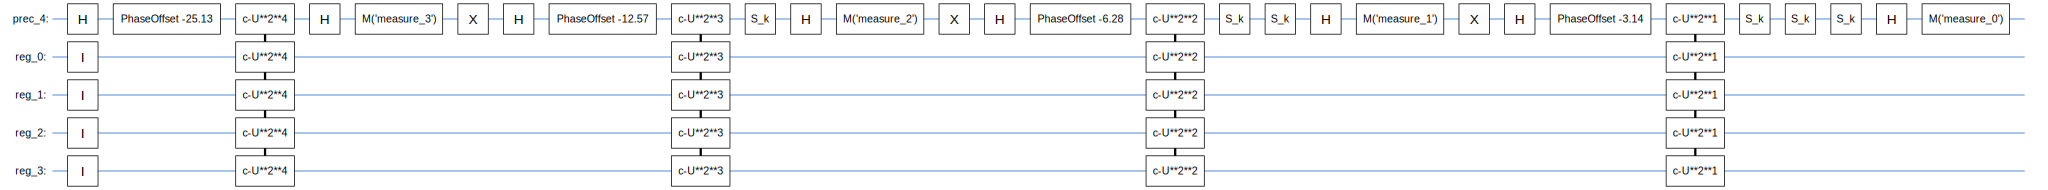

In [4]:
###
### Note: the larger your circuit, the
### longer the circuit takes to render
###
SVGCircuit(gse_circuit)

## Decompose circuit and export to OpenQasm 2.0

In [5]:
###
### Print out to the screen:
###

decomposed_once_circuit = qsp_decompose_once(gse_circuit)
decomposed_circuit      = qsp_decompose_once(decomposed_once_circuit)
print ('done with this')

### Decompose into clifford+T:
cliff_plus_T_circuit    = clifford_plus_t_direct_transform(decomposed_circuit)

print_to_openqasm(sys.stdout, cliff_plus_T_circuit, qubits=cliff_plus_T_circuit.all_qubits())


done with this
// Generated from Cirq v1.0.0
OPENQASM 2.0;
include "qelib1.inc";
// Qubits: [prec_4, reg_3, reg_0, reg_2, reg_1]
// Cirq -> OpenQASM Map : 'prec_4': 'q[0]', 'reg_3': 'q[1]', 'reg_0': 'q[2]', 'reg_2': 'q[3]', 'reg_1': 'q[4]'
qreg q[5];
creg m_measure_3[1];
creg m_measure_2[1];
creg m_measure_1[1];
creg m_measure_0[1];
h q[0];
h q[2];
h q[4];
h q[3];
h q[1];
id q[0];
s q[3];
s q[1];
sdg q[4];
h q[0];
h q[3];
h q[1];
h q[4];
id q[0];
sdg q[4];
sdg q[3];
sdg q[1];
h q[0];
h q[4];
h q[3];
h q[1];
id q[0];
s q[4];
sdg q[3];
sdg q[1];
cz q[2],q[4];
h q[3];
h q[1];
sdg q[4];
s q[3];
s q[1];
h q[4];
s q[4];
h q[4];
s q[4];
cz q[4],q[3];
sdg q[3];
h q[3];
s q[3];
h q[3];
s q[3];
cz q[3],q[1];
sdg q[1];
h q[1];
s q[1];
h q[1];
s q[1];
cx q[0],q[1];
z q[1];
t q[1];
h q[1];
t q[1];
h q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[

In [6]:
###
### Or save the OpenQASM 2.0 format to a file:
###

#Write it.
with open('my_H2_GSE_example_qasm.qasm','w') as f:
    print_to_openqasm(f, cliff_plus_T_circuit,qubits=cliff_plus_T_circuit.all_qubits())

#Read it.
with open('my_H2_GSE_example_qasm.qasm','r') as f:
    lines = "".join(f.readlines())
    print(lines)

#Delete it.
os.remove('my_H2_GSE_example_qasm.qasm')


// Generated from Cirq v1.0.0
OPENQASM 2.0;
include "qelib1.inc";
// Qubits: [prec_4, reg_3, reg_0, reg_2, reg_1]
// Cirq -> OpenQASM Map : 'prec_4': 'q[0]', 'reg_3': 'q[1]', 'reg_0': 'q[2]', 'reg_2': 'q[3]', 'reg_1': 'q[4]'
qreg q[5];
creg m_measure_3[1];
creg m_measure_2[1];
creg m_measure_1[1];
creg m_measure_0[1];
h q[0];
h q[2];
h q[4];
h q[3];
h q[1];
id q[0];
s q[3];
s q[1];
sdg q[4];
h q[0];
h q[3];
h q[1];
h q[4];
id q[0];
sdg q[4];
sdg q[3];
sdg q[1];
h q[0];
h q[4];
h q[3];
h q[1];
id q[0];
s q[4];
sdg q[3];
sdg q[1];
cz q[2],q[4];
h q[3];
h q[1];
sdg q[4];
s q[3];
s q[1];
h q[4];
s q[4];
h q[4];
s q[4];
cz q[4],q[3];
sdg q[3];
h q[3];
s q[3];
h q[3];
s q[3];
cz q[3],q[1];
sdg q[1];
h q[1];
s q[1];
h q[1];
s q[1];
cx q[0],q[1];
z q[1];
t q[1];
h q[1];
t q[1];
h q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q[1];
h q[1];
s q[1];
t q